In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [3]:
### 2. Load Preprocessed Data
# Assumes 01_data_cleaning.ipynb saved cleaned data to /data/processed/cleaned_data.csv

df = pd.read_csv('data/processed/diabetes_cleaned.csv')
df.head()


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,35,1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,45,1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [4]:
# Separate features and target
X_raw = df.drop('readmitted', axis=1)
y = df['readmitted']

# Identify categorical columns
cat_cols = X_raw.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

# One-hot encode categorical features
X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

# Save feature names for SHAP
feature_names = X.columns.tolist()


Categorical columns: ['race', 'gender', 'diag_1', 'diag_2', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [5]:
### 4. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (81412, 1530)
Test shape: (20354, 1530)


In [6]:
### 4. Model Definitions
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED)
}

results = {}


In [7]:
### 5. Train, Evaluate, and Store Each Model
for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name} ROC AUC Score: {auc:.4f}")
    
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "roc_auc": auc
    }



🔍 Training Logistic Regression...
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.50      0.02      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354

Logistic Regression ROC AUC Score: 0.6458

🔍 Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     18083
           1       0.17      0.59      0.26      2271

    accuracy                           0.63     20354
   macro avg       0.55      0.61      0.51     20354
weighted avg       0.84      0.63      0.70     20354

Random Forest ROC AUC Score: 0.6569

🔍 Training XGBoost...


/Users/shrey/Downloads/explainable-health-optimizer/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.52      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.71      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354

XGBoost ROC AUC Score: 0.6802

🔍 Training LightGBM...
[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 601
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
LightGBM Classification Report

<Figure size 1000x600 with 0 Axes>

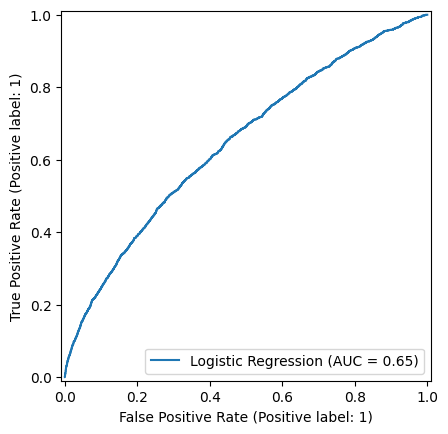

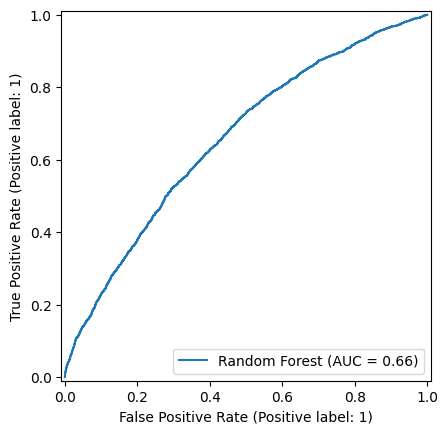

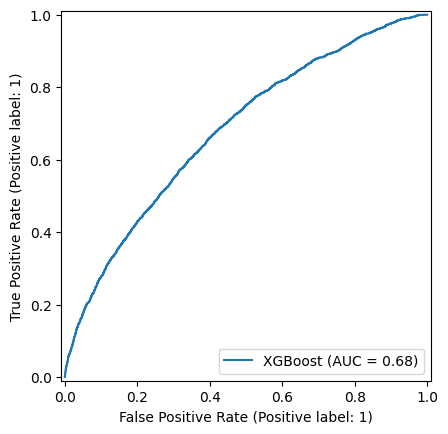

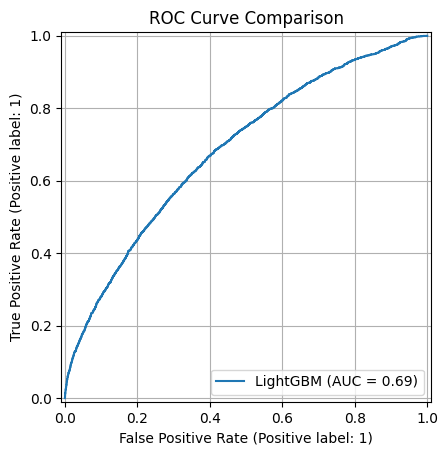

In [8]:
### 6. Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, res in results.items():
    RocCurveDisplay.from_predictions(y_test, res['y_prob'], name=name)
plt.title("ROC Curve Comparison")
plt.grid()
plt.show()



✅ Best Model Based on AUC: LightGBM


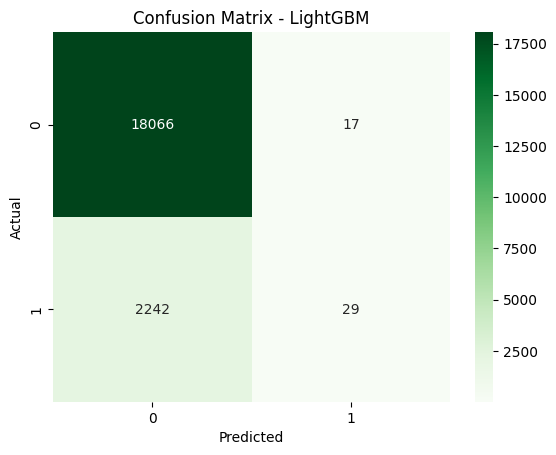

In [9]:
### 7. Confusion Matrix for Best Model
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

print(f"\n✅ Best Model Based on AUC: {best_model_name}")
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
# Save best model
best_model_path = f"models/{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump({'model': best_model, 'features': feature_names}, best_model_path)

# Save best model name to a text file
with open("models/best_model.txt", "w") as f:
    f.write(best_model_path)

print(f"✅ Saved best model to {best_model_path}")


✅ Saved best model to models/lightgbm.pkl
